# Autoencoders

In [1]:
# Autoreloading makes development easier
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow_probability as tfp
import json
from sklearn.model_selection import train_test_split
from tools.audio_tools import read_audio, write_audio, play_audio
from tools.feature_tools import compute_mels, compute_imels, compute_mfcc, compute_imfcc, load_data, normalize_features, denormalize_features
from tools.constants import npy_classical_path, npy_jazz_path, models_path
from tools.plot_tools import make_figax, plot_history, plot_audio, plot_spectral_feature
from tools.tensorflow_tools import tune_hyperparameters, load_optimal_params

2023-11-26 18:58:13.528882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 18:58:13.567444: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 18:58:13.567484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 18:58:13.567516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 18:58:13.575241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 18:58:13.575885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Data Loading

### Load Audio & Extract Features

In [3]:
# Load samples from both styles
n_samples = 30000
n_samples = min(n_samples, len(os.listdir(npy_classical_path)), len(os.listdir(npy_jazz_path)))
print(f"{n_samples = }")
X_classical_raw = load_data(npy_classical_path, n_samples=n_samples)
X_jazz_raw = load_data(npy_jazz_path, n_samples=n_samples)

# Concatenate (train on all samples)
X_raw = np.concatenate((X_classical_raw, X_jazz_raw))

# Print feature shape
print(f"{X_raw.shape = }")

n_samples = 418
100 %
100 %
X_raw.shape = (836, 67, 128, 1)


### Train - Validation - Test Split

In [4]:
# Fraction of data to keep apart for validation
test_size = round(0.1 * len(X_raw))
val_size = test_size
# Perform split
X_raw_train, X_raw_test = train_test_split(X_raw, test_size=test_size, random_state=1234)
X_raw_train, X_raw_val = train_test_split(X_raw_train, test_size=val_size, random_state=1234)
# Verify split shapes
print(f"{X_raw_train.shape = }")
print(f"{X_raw_test.shape = }")
print(f"{X_raw_val.shape = }")

X_raw_train.shape = (668, 67, 128, 1)
X_raw_test.shape = (84, 67, 128, 1)
X_raw_val.shape = (84, 67, 128, 1)


In [5]:
input_shape = X_raw_train.shape[1:]
print(f"{input_shape = }")

input_shape = (67, 128, 1)


### Normalize Features

In [6]:
# Perform normalization
X_train, X_val, X_test = normalize_features(X_raw_train, X_raw_val=X_raw_val, X_raw_test=X_raw_test)

print(f"{X_train.shape = }")
print(f"{X_val.shape = }")
print(f"{X_test.shape = }")

X_train.shape = (668, 67, 128, 1)
X_val.shape = (84, 67, 128, 1)
X_test.shape = (84, 67, 128, 1)


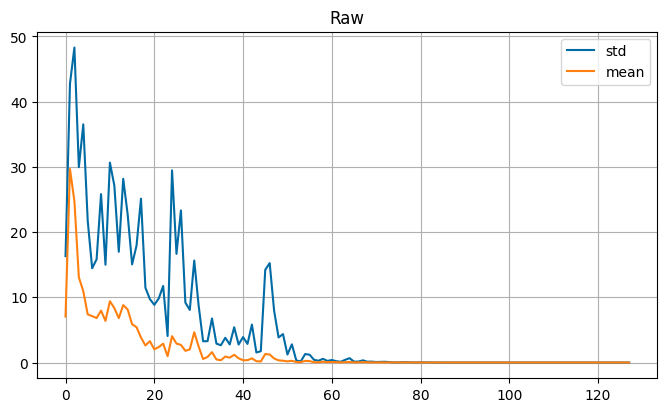

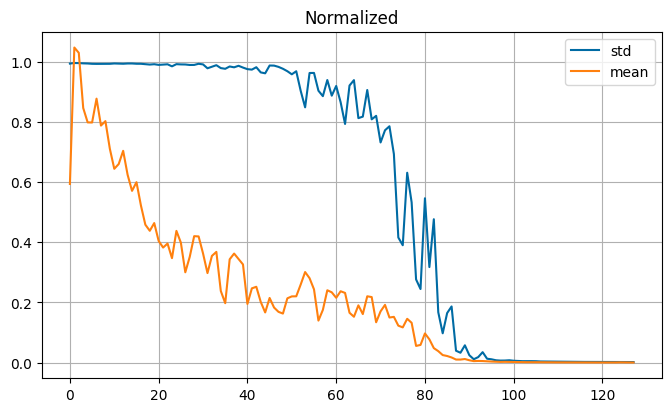

In [7]:
# See the effect of normalization
fig, ax = make_figax()
ax.plot(np.std(X_raw_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_raw_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_raw_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Raw")
plt.show()


fig, ax = make_figax()
ax.plot(np.std(X_train, axis=(0,1,3)), label="std")
ax.plot(np.mean(X_train, axis=(0,1,3)), label="mean")
#ax.plot(np.max(X_train, axis=(0,1,3)), label="max")
ax.grid()
ax.legend()
ax.set_title("Normalized")
plt.show()

## Autoencoders

### Test Script

In [8]:
nop = lambda x: x

def test_autoencoder(autoencoder, test_set = X_test, plot_transforms = True, plot_raw_transforms = True, plot_waveforms = True):
  # Pick sample at random
  print("Picking Sample")
  choice = np.random.choice(len(test_set))
  x = test_set[choice]

  # Autencoder
  print("Autencoding")
  x_hat = np.array(autoencoder(x.reshape((1, *x.shape))))

  if plot_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x, fn=nop)
    ax.set_title("Original Preprocessed Spectrum")
    fig, ax = plot_spectral_feature(x_hat, fn=nop)
    ax.set_title("Reconstructed Preprocessed Spectrum")
    plt.show()

  # Postprocess
  print("Postprocessing")
  x_raw = denormalize_features(x.reshape((1, *x.shape)))[0]
  x_raw_hat = denormalize_features(x_hat.reshape((1, *x.shape)))[0]

  if plot_raw_transforms:
    print("Plotting transforms")
    fig, ax = plot_spectral_feature(x_raw)
    ax.set_title("Original Raw Spectrum")
    fig, ax = plot_spectral_feature(x_raw_hat)
    ax.set_title("Reconstructed Raw Spectrum")
    plt.show()

  # Reconstruct Audio
  print("Reconstructing Audio")
  s = np.squeeze(compute_imels(x_raw))
  s_hat = np.squeeze(compute_imels(x_raw_hat))

  if plot_waveforms:
    fig, ax = plot_audio(s)
    ax.set_title("Original Waveform")
    fig, ax = plot_audio(s_hat)
    ax.set_title("Reconstructed Waveform")
    plt.show()

  # Play audio
  print("Original Audio")
  player = play_audio(s)
  print("Reconstructed Audio")
  player = play_audio(s_hat)
  print()

In [9]:
def free_memory(autoencoder):
  krs.backend.clear_session()
  del autoencoder.encoder
  del autoencoder.decoder
  del autoencoder
  krs.backend.clear_session()

In [10]:
os.makedirs(models_path, exist_ok = True)
def save_autoencoder(autoencoder, params, history, name):
    # Define and make directory
    autoencoder_path = os.path.join(models_path, name)
    os.makedirs(autoencoder_path, exist_ok = True)
    
    # Save parameters
    with open(os.path.join(autoencoder_path, "params.json"), "w") as params_file:
        json.dump(params, params_file)
        
    # Save history
    with open(os.path.join(autoencoder_path, "history.json"), "w") as history_file:
        if not isinstance(history, dict):
            history = history.history
        json.dump(history, history_file)
    
    # Save model
    autoencoder.save(os.path.join(autoencoder_path, "model.keras"))

def load_autoencoder(name, load_model = True):
    # Define path
    autoencoder_path = os.path.join(models_path, name)
    
    # Load parameters
    with open(os.path.join(autoencoder_path, "params.json"), "r") as params_file:
        params = json.load(params_file)
    
    # Load history
    with open(os.path.join(autoencoder_path, "history.json"), "r") as history_file:
        history = json.load(history_file)
    
    # Load model
    autoencoder = None
    if load_model:
        autoencoder = krs.models.load_model(os.path.join(autoencoder_path, "model.keras"))
    
    return autoencoder, params, history

### Convolutional Autoencoder

In [15]:
from models.autoencoders import Conv2DAutoencoder

In [16]:
default_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 3,
    "conv_depth": 1,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
}

compile_kwargs = {
    "optimizer": "adam",
    "loss": "mae",
}


In [17]:
# Test training
autoencoder = Conv2DAutoencoder(**default_params)
autoencoder.compile(**compile_kwargs)
history = autoencoder.fit(X_train, X_train, epochs=1, shuffle=True, validation_data=(X_val, X_val), verbose=1)

2023-11-25 20:39:22.215781: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1646592000 exceeds 10% of free system memory.


1500/1500 [==============================] - 8s 4ms/step - loss: 0.0997 - val_loss: 0.0851


In [18]:
# Hyperparameter tuning
results_path = os.path.join("./results/Conv2DAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "input_chans_multiplier",
    "conv_depth",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 2, 4],
    [1, 2, 3],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key = "val_loss"
epochs = 250
passes = 1

In [12]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    Conv2DAutoencoder,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=False,
    do_random=True,
    random_attempts=25,
)

Optimizing for default parameters
loss = 0.09975945204496384
Optimizing for random choice 1 / 25
loss = 0.1921980381011963
Optimizing for random choice 2 / 25
loss = 0.08583929389715195
Optimizing for random choice 3 / 25
loss = 0.1920371800661087
Optimizing for random choice 4 / 25
loss = 0.09792078286409378
Optimizing for random choice 5 / 25
loss = 0.0919201672077179
Optimizing for random choice 6 / 25
loss = 0.18661250174045563
Optimizing for random choice 7 / 25
loss = 0.09526059031486511
Optimizing for random choice 8 / 25
loss = 0.09775575250387192
Optimizing for random choice 9 / 25
loss = 0.1920638382434845
Optimizing for random choice 10 / 25
loss = 0.08675667643547058
Optimizing for random choice 11 / 25
loss = 0.09293419867753983
Optimizing for random choice 12 / 25
loss = 0.09596198052167892
Optimizing for random choice 13 / 25
loss = 0.1865614503622055
Optimizing for random choice 14 / 25
loss = 0.19218720495700836
Optimizing for random choice 15 / 25
loss = 0.10039006918

In [22]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 2, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.0815010517835617


In [ ]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        Conv2DAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=False,
        do_random=False,
    )

In [25]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 1, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.08437574654817581


In [20]:
# Load optimal hyperparameters from tuning process
optimal_params, optimal_loss = load_optimal_params(results_path, loss_key)

In [21]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 2, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average'}
optimal_loss = 0.0815010517835617


In [23]:
# Manual tuning
optimal_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
}

In [24]:
# Retrain with optimal params
autoencoder = Conv2DAutoencoder(**optimal_params)
autoencoder.compile(**compile_kwargs)
earlystopping = krs.callbacks.EarlyStopping(monitor=loss_key, patience=5, min_delta=1e-6)
history = autoencoder.fit(X_train, X_train, epochs=250, shuffle=True, validation_data=(X_val, X_val), callbacks=[earlystopping], verbose=1)

Epoch 1/250
1500/1500 [==============================] - 13s 7ms/step - loss: 0.1025 - val_loss: 0.0824
Epoch 2/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0754 - val_loss: 0.0716
Epoch 3/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0691 - val_loss: 0.0676
Epoch 4/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 5/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0643 - val_loss: 0.0640
Epoch 6/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0629 - val_loss: 0.0633
Epoch 7/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0620 - val_loss: 0.0618
Epoch 8/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0611 - val_loss: 0.0617
Epoch 9/250
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0605 - val_loss: 0.0608
Epoch 10/250
1500/1500 [==============================] - 9s 6ms/step - 

In [25]:
# Save model
autoencoder.save(os.path.join(results_path, "model.keras"))

In [26]:
# Make sure loading works
autoencoder = krs.models.load_model(os.path.join(results_path, "model.keras"))

Picking Sample
Autencoding
Postprocessing
Plotting transforms


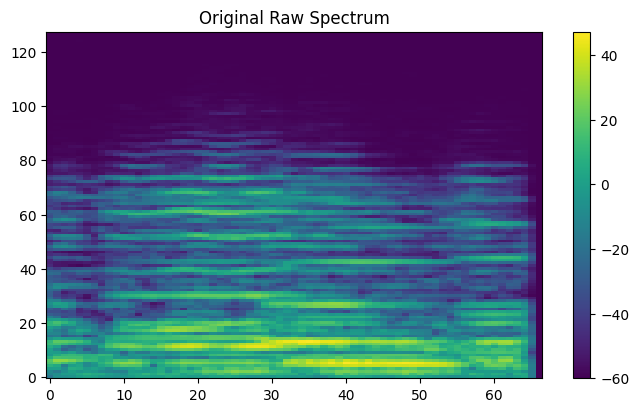

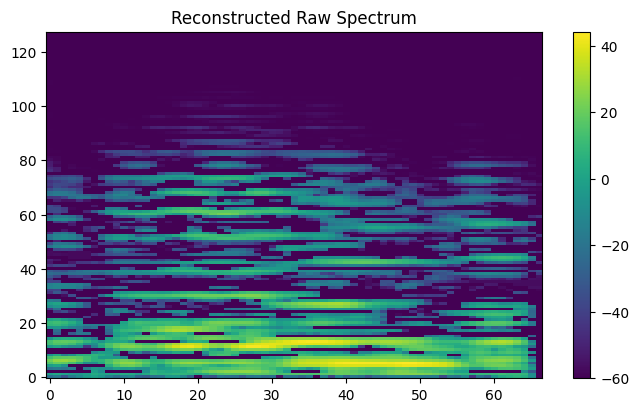

Reconstructing Audio
Original Audio


Reconstructed Audio


In [27]:
# Test autoencoder
test_autoencoder(autoencoder, X_test, False, True, False)

### Variational Autencoder

In [12]:
from models.autoencoders import VariationalAutoencoder

In [13]:
default_params = {
    "feature_shape": input_shape,
    "compression": 8,
    "kernel_size": 3,
    "conv_depth": 1,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "kl_reg": 1,
}

In [14]:
print(f"{default_params = }")

default_params = {'feature_shape': (67, 128, 1), 'compression': 8, 'kernel_size': 3, 'conv_depth': 1, 'input_chans_multiplier': 1, 'skip_connection': False, 'pooling_type': 'average', 'kl_reg': 1}


In [ ]:
# Test Training
autoencoder = VariationalAutoencoder(**default_params)
autoencoder.compile(optimizer="adam")
history = autoencoder.fit(X_train, X_train, epochs=1, shuffle=True, validation_data=(X_val, X_val), verbose=1)

In [16]:
# Hyperparameter tuning
results_path = os.path.join("./results/VariationalAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "kl_reg",
    "input_chans_multiplier",
    "conv_depth",
    "kernel_size",
    "pooling_type",
])
vals = np.array([
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    [1, 2, 4],
    [1, 2, 3],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key="val_r_loss"
epochs = 250
passes = 1
optimal_params = default_params.copy()

In [19]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    VariationalAutoencoder,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=False,
    do_random=True,
    random_attempts=25,
)

Optimizing for default parameters
loss = nan
Optimizing for random choice 1 / 25
loss = 0.1926874965429306
Optimizing for random choice 2 / 25
loss = 0.19166357815265656
Optimizing for random choice 3 / 25
loss = 0.15279941260814667
Optimizing for random choice 4 / 25
loss = nan
Optimizing for random choice 5 / 25
loss = 0.1926848292350769
Optimizing for random choice 6 / 25
loss = 0.16945780813694
Optimizing for random choice 7 / 25
loss = 0.19150233268737793
Optimizing for random choice 8 / 25
loss = 0.1926848292350769
Optimizing for random choice 9 / 25
loss = 0.16292360424995422
Optimizing for random choice 10 / 25
loss = 0.1926848292350769
Optimizing for random choice 11 / 25
loss = 0.18279004096984863
Optimizing for random choice 12 / 25
loss = 0.1537982076406479
Optimizing for random choice 13 / 25
loss = 0.19268479943275452
Optimizing for random choice 14 / 25
loss = 0.19164592027664185
Optimizing for random choice 15 / 25
loss = 0.15214131772518158
Optimizing for random choice

In [20]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': (67, 128, 1), 'compression': 8, 'kernel_size': 5, 'conv_depth': 2, 'input_chans_multiplier': 2, 'skip_connection': False, 'pooling_type': 'max', 'kl_reg': 1}
optimal_loss = 0.13921760022640228


In [ ]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        VariationalAutoencoder,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        verbose=False,
        do_random=False,
    )

In [31]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 3, 'conv_depth': 3, 'input_chans_multiplier': 2, 'skip_connection': False, 'pooling_type': 'max', 'kl_reg': 0.001}
optimal_loss = 0.10728611797094345


In [34]:
# Load optimal hyperparameters from tuning process
optimal_params, optimal_loss = load_optimal_params(results_path, loss_key)

In [35]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'compression': 8, 'kernel_size': 5, 'conv_depth': 2, 'input_chans_multiplier': 2, 'skip_connection': False, 'pooling_type': 'max', 'kl_reg': 1}
optimal_loss = 0.13921760022640228


In [17]:
# Manual parameter tuning
optimal_params = {
    "feature_shape": input_shape,
    "compression": 4,
    "kernel_size": 5,
    "conv_depth": 2,
    "input_chans_multiplier": 1,
    "skip_connection": False,
    "pooling_type": "average",
    "kl_reg": 1e-2,
}

In [18]:
# Retrain with all data & optimal parameters
autoencoder = VariationalAutoencoder(**optimal_params)
autoencoder.compile(optimizer="adam")
earlystopping = krs.callbacks.EarlyStopping(monitor="val_r_loss", patience=5, min_delta=1e-6)
history = autoencoder.fit(X_train, X_train, epochs=250, shuffle=True, validation_data=(X_val, X_val), callbacks=[earlystopping], verbose=1)

Epoch 1/250
1500/1500 [==============================] - 19s 10ms/step - loss: 0.1978 - r_loss: 0.1943 - kl_loss: 0.3538 - val_loss: 0.1971 - val_r_loss: 0.1934 - val_kl_loss: 0.3685
Epoch 2/250
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1757 - r_loss: 0.1711 - kl_loss: 0.4587 - val_loss: 0.1417 - val_r_loss: 0.1348 - val_kl_loss: 0.6825
Epoch 3/250
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1258 - r_loss: 0.1193 - kl_loss: 0.6457 - val_loss: 0.1158 - val_r_loss: 0.1086 - val_kl_loss: 0.7271
Epoch 4/250
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1096 - r_loss: 0.1024 - kl_loss: 0.7167 - val_loss: 0.1064 - val_r_loss: 0.0984 - val_kl_loss: 0.8020
Epoch 5/250
1500/1500 [==============================] - 13s 9ms/step - loss: 0.1031 - r_loss: 0.0955 - kl_loss: 0.7573 - val_loss: 0.1052 - val_r_loss: 0.0969 - val_kl_loss: 0.8334
Epoch 6/250
1500/1500 [==============================] - 13s 9ms/step - loss: 0.0998 - r_

In [19]:
# Save model
autoencoder.save(os.path.join(results_path, "model.keras"))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [23]:
autoencoder.save_weights(os.path.join(results_path, "weights"))

In [24]:
# Make sure loading works
autoencoder = krs.models.load_model(os.path.join(results_path, "model.keras"))

In [26]:
autoencoder.load_weights(os.path.join(results_path, "weights"))

Picking Sample
Autencoding
Postprocessing
Plotting transforms


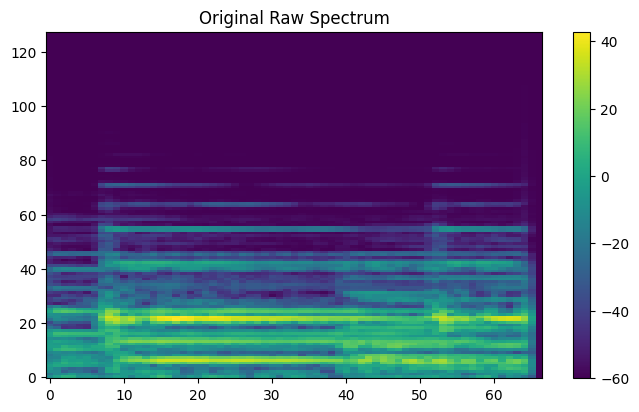

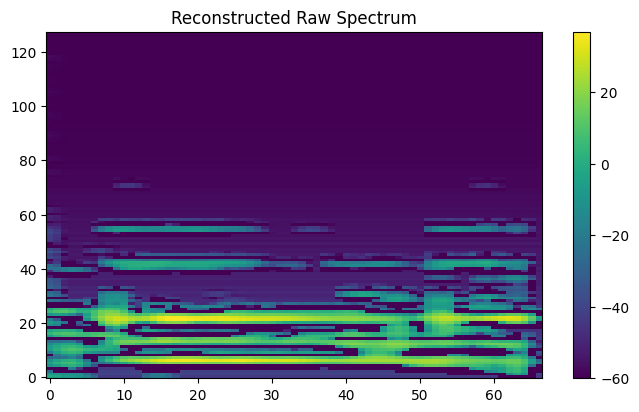

Reconstructing Audio
Original Audio


Reconstructed Audio


In [29]:
test_autoencoder(autoencoder, X_test, False, True, False)

In [ ]:
# TODO: Test creating multiple variations of the same input data


### GAN Autoencoder

In [14]:
from models.autoencoders import GANGenerator, GANDiscriminator
from models.layers import GAN

In [15]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    
    # Instantiate model
    generator = GANGenerator(**g_params)
    discriminator = GANDiscriminator(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [26]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 8,
    "g_kernel_size": 3,
    "g_conv_depth": 1,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.1,
    "g_c_reg": 0.1,
    "g_s_reg": 0.1,
    "g_mode": "adain",
    "g_hidden_activation": "relu",
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

In [27]:
# Test training
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)
history = gan.fit(X_train, X_train, epochs=1, shuffle=True, verbose=1, validation_data=(X_val, X_val))

21/21 [==============================] - 9s 223ms/step - loss: 0.6367 - r_loss: 0.2155 - gan_loss: 3.4025 - c_loss: 0.0064 - s_loss: 0.8033 - d_loss: 0.2961 - val_loss: 0.7118 - val_r_loss: 0.2303 - val_gan_loss: 4.0089 - val_c_loss: 0.0072 - val_s_loss: 0.7981 - val_d_loss: 0.1722


In [18]:
# Hyperparameter tuning
results_path = os.path.join("./results/GANAutoencoder")
os.makedirs(results_path, exist_ok=True)
keys = np.array([
    "g_gan_reg",
    "g_c_reg",
    "g_s_reg",
    "g_input_chans_multiplier",
    "g_conv_depth",
    "g_kernel_size",
    "g_pooling_type",
])
vals = np.array([
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    [1, 2, 4],
    [1, 2, 3],
    [3, 5],
    ["max", "average"],
], dtype="object")
loss_key="val_r_loss"
epochs = 250
passes = 1
optimal_params = default_params.copy()

In [ ]:
# Random optimization
optimal_params, optimal_loss = tune_hyperparameters(
    X_train,
    X_train,
    create_gan_model,
    default_params,
    keys,
    vals,
    loss_key,
    X_val=X_val,
    y_val=X_val,
    results_path=results_path,
    epochs=epochs,
    compile_kwargs=compile_kwargs,
    verbose=False,
    do_random=True,
    random_attempts=25,
)

In [27]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': (67, 128, 1), 'g_compression': 8, 'g_kernel_size': 5, 'g_conv_depth': 1, 'g_input_chans_multiplier': 2, 'g_skip_connection': False, 'g_pooling_type': 'average', 'g_gan_reg': 1e-05, 'g_c_reg': 0.0001, 'g_s_reg': 0.1, 'd_mlp_layers': 2, 'd_conv_compression': 8, 'd_conv_kernel_size': 3, 'd_conv_pooling_type': 'max'}
optimal_loss = 0.07930829375982285


In [ ]:
# Sequential optimization
for i in range(passes):
    # Random optimization
    permutation = np.random.permutation(len(keys))
    optimal_params, optimal_loss = tune_hyperparameters(
        X_train,
        X_train,
        create_gan_model,
        optimal_params,
        keys[permutation],
        vals[permutation],
        loss_key,
        X_val=X_val,
        y_val=X_val,
        results_path=results_path,
        epochs=epochs,
        compile_kwargs=compile_kwargs,
        verbose=False,
        do_random=False,
    )

In [18]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'g_compression': 8, 'g_kernel_size': 5, 'g_conv_depth': 1, 'g_input_chans_multiplier': 1, 'g_skip_connection': True, 'g_pooling_type': 'average', 'g_gan_reg': 0.0001, 'g_c_reg': 0.01, 'g_s_reg': 0.0001, 'd_mlp_layers': 2, 'd_conv_compression': 8, 'd_conv_kernel_size': 3, 'd_conv_pooling_type': 'max'}
optimal_loss = 0.2928396463394165


In [34]:
# Load optimal hyperparameters from tuning process
optimal_params, optimal_loss = load_optimal_params(results_path, loss_key)

In [35]:
print(f"{optimal_params = }")
print(f"{optimal_loss = }")

optimal_params = {'feature_shape': [67, 128, 1], 'g_compression': 8, 'g_kernel_size': 5, 'g_conv_depth': 1, 'g_input_chans_multiplier': 2, 'g_skip_connection': False, 'g_pooling_type': 'average', 'g_gan_reg': 1e-05, 'g_c_reg': 0.0001, 'g_s_reg': 0.1, 'd_mlp_layers': 2, 'd_conv_compression': 8, 'd_conv_kernel_size': 3, 'd_conv_pooling_type': 'max'}
optimal_loss = 0.07930829375982285


In [48]:
# Manual parameter tuning
optimal_params = {
    "feature_shape": input_shape,
    "g_compression": 4,
    "g_kernel_size": 5,
    "g_conv_depth": 2,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.02,
    "g_c_reg": 0.01,
    "g_s_reg": 0.05,
    "g_concatentate": False,
    "g_hidden_activation": "sigmoid",
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

In [49]:
# Retrain with optimal params
gan = create_gan_model(**optimal_params)
gan.compile(**compile_kwargs)
earlystopping = krs.callbacks.EarlyStopping(monitor="val_r_loss", patience=5, min_delta=1e-6)
history = gan.fit(X_train, X_train, epochs=250, shuffle=True, verbose=1, callbacks=[earlystopping], validation_data=(X_val, X_val))

Epoch 1/250
1500/1500 [==============================] - 29s 16ms/step - loss: 0.2327 - r_loss: 0.1475 - gan_loss: 3.4656 - c_loss: 0.0773 - s_loss: 0.3025 - d_loss: 0.1971 - val_loss: 0.2098 - val_r_loss: 0.1367 - val_gan_loss: 2.8716 - val_c_loss: 0.1153 - val_s_loss: 0.2912 - val_d_loss: 0.2431
Epoch 2/250
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2083 - r_loss: 0.1212 - gan_loss: 3.5880 - c_loss: 0.1073 - s_loss: 0.2858 - d_loss: 0.1565 - val_loss: 0.2069 - val_r_loss: 0.1159 - val_gan_loss: 3.8018 - val_c_loss: 0.0641 - val_s_loss: 0.2855 - val_d_loss: 0.0924
Epoch 3/250
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2026 - r_loss: 0.1149 - gan_loss: 3.6105 - c_loss: 0.0936 - s_loss: 0.2911 - d_loss: 0.1512 - val_loss: 0.1994 - val_r_loss: 0.1187 - val_gan_loss: 3.1278 - val_c_loss: 0.1634 - val_s_loss: 0.3295 - val_d_loss: 0.3719
Epoch 4/250
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1980 - r_loss: 0.1152 

In [57]:
# Save model
gan.generator.save(os.path.join(results_path, "generator.keras"))

In [127]:
# Load model
generator = krs.models.load_model(os.path.join(results_path, "generator.keras"))
gan = GAN(generator, None)

In [50]:
# Test model
def autoencoder_real(X):
    X_real, X_fake = gan.generator(X)
    return np.array(X_real)

def autoencoder_fake(X):
    X_real, X_fake = gan.generator(X)
    return np.array(X_fake)

Picking Sample
Autencoding
Postprocessing
Plotting transforms


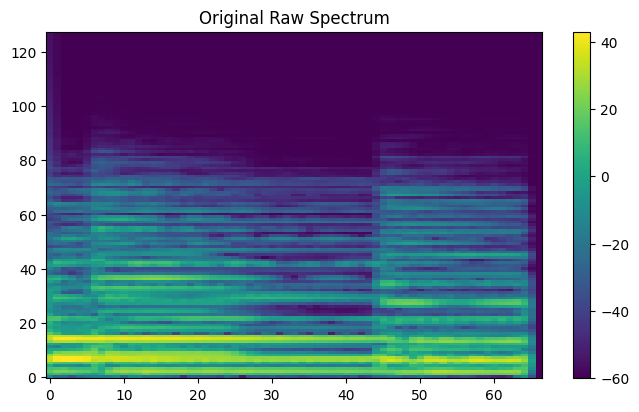

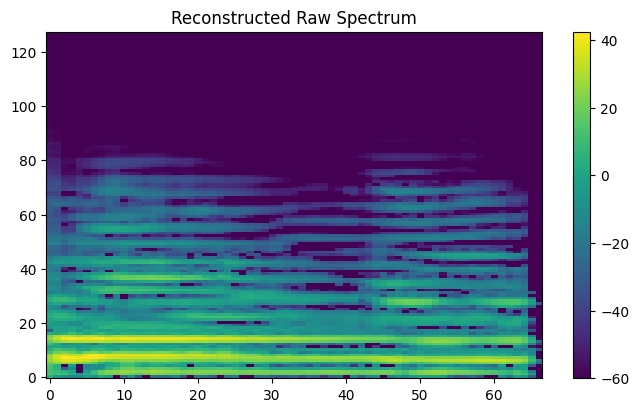

Reconstructing Audio
Original Audio


Reconstructed Audio


In [56]:
test_autoencoder(autoencoder_real, X_test, False, True, False)

Picking Sample
Autencoding
Postprocessing
Plotting transforms


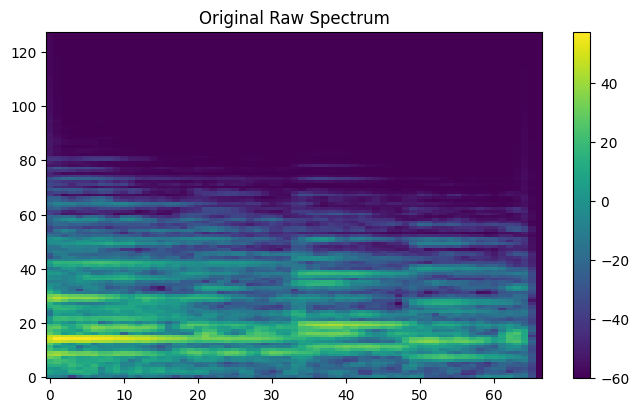

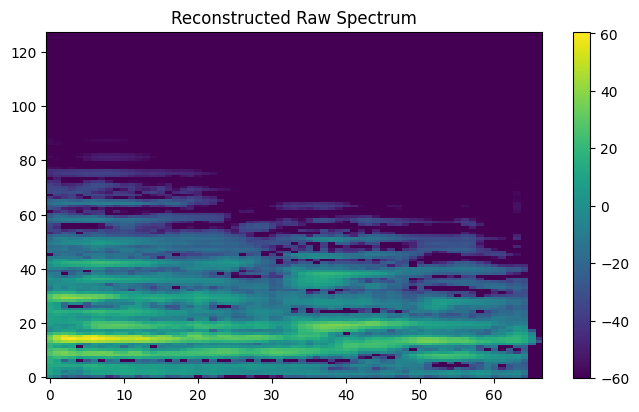

Reconstructing Audio
Original Audio


Reconstructed Audio


In [55]:
test_autoencoder(autoencoder_fake, X_test, False, True, False)

### MUNIT Autoencoder

In [11]:
from models.autoencoders import MUNITGenerator, GANDiscriminator
from models.layers import GAN

In [12]:
def create_gan_model(**params):
    # Split generator & discriminator params
    g_params = {}
    d_params = {}
    for key, value in params.items():
        if key[:2] == "g_":
            # Generator param
            g_params[key[2:]] = value
        elif key[:2] == "d_":
            # Discriminator param
            d_params[key[2:]] = value
        else:
            # Shared param
            g_params[key] = value
            d_params[key] = value
    
    # Instantiate model
    generator = MUNITGenerator(**g_params)
    discriminator = GANDiscriminator(**d_params)
    gan = GAN(generator, discriminator)
    return gan

In [26]:
default_params = {
    "feature_shape": input_shape,
    "g_compression": 8,
    "g_style_dim": 8,
    "g_kernel_size": 3,
    "g_conv_depth": 1,
    "g_input_chans_multiplier": 1,
    "g_skip_connection": False,
    "g_pooling_type": "average",
    "g_gan_reg": 0.1,
    "g_c_reg": 0.1,
    "g_s_reg": 0.1,
    "g_adain_momentum": 0.1,
    "g_adain_epsilon": 1e-5,
    "d_mlp_layers": 2,
    "d_conv_compression": 8,
    "d_conv_kernel_size": 3,
    "d_conv_pooling_type": "max",
}

compile_kwargs={
    "g_optimizer": "adam",
    "d_optimizer": "adam",
}

In [31]:
# Test training
gan = create_gan_model(**default_params)
gan.compile(**compile_kwargs)

In [32]:
history = gan.fit(X_train, X_train, epochs=1, shuffle=True, verbose=1, validation_data=(X_val, X_val))

Training
Training
Training
Training
Training
Training
Training
Training
21/21 [==============================] - ETA: 0s - loss: 0.6257 - r_loss: 0.2259 - gan_loss: 3.1481 - c_loss: 0.0087 - s_loss: 0.8406 - d_loss: 0.3650Training
Training
Training
Training
21/21 [==============================] - 10s 239ms/step - loss: 0.6257 - r_loss: 0.2259 - gan_loss: 3.1481 - c_loss: 0.0087 - s_loss: 0.8406 - d_loss: 0.3650 - val_loss: 0.5884 - val_r_loss: 0.2418 - val_gan_loss: 2.7578 - val_c_loss: 0.0141 - val_s_loss: 0.6948 - val_d_loss: 0.2169
